In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import keras
import keras.backend as Kback
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers.core import Activation
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

model_path = 'RNN_regression_PCA.h5'

# RNN_regression_PCA : First model with the highest accuracy 
# RNN_regression_PCA_1: Increasing the variability explained by PCA from 0.95 to 0.98
# RNN_regression_PCA_2: Reducing the sequence from 50 to 30
# RNN_regression_PCA_3: Increasing the sequence from 50 to 60

import random
random.seed(123)


Using TensorFlow backend.


In [2]:
from math import e

In [3]:
#######
#Data ingestion & processing
######

train_df = pd.read_csv("C:/Users/eduardo.tadeo/Documents/Master Thesis/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/Documents/Master Thesis/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/Documents/Master Thesis/Datasets/CMAPSSData/RUL_FD001.txt")

#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables and operational conditions

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df[cols_normalize])
norm_train_df = pd.DataFrame(scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# Principal Component Analysis Dimensionality Reduction

pca = PCA(.95)

pca.fit(norm_train_df)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']


# Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

train_df['UL_30'] = np.where(train_df['RUL'] <= 30, 1, 0)
train_df['UL_50'] = np.where(train_df['RUL'] <= 50, 1, 0)
train_df['UL_75'] = np.where(train_df['RUL'] <= 75, 1, 0)




In [4]:
norm_train_df.isna().any()

BPR           False
Cycle_norm    False
NRc           False
NRf           False
Nc            False
Nf            False
Nf_dmd        False
OP1           False
OP2           False
OP3           False
P15           False
P2            False
P30           False
PCNfR_dmd     False
Ps30          False
T2            False
T24           False
T30           False
T50           False
W31           False
W32           False
epr           False
farB          False
htBleed       False
phi           False
dtype: bool

In [5]:
train_df.head()


,Cycle,Unit,0,1,2,3,4,5,6,7,8,9,10,11,12,UL,RUL,UL_30,UL_50,UL_75
0,1,1,-3.240845,-0.559371,-1.176731,0.489354,-0.674640,0.769576,-0.669039,0.631733,-0.421074,0.039968,0.643934,0.289824,0.222595,192,191,0,0,0
1,2,1,-2.669143,-0.940659,-0.137753,1.167902,-0.706549,0.927689,-0.789666,0.287941,-0.121802,-0.306724,0.658158,0.108694,-0.231444,192,190,0,0,0
2,3,1,-3.260073,-0.665652,-0.528376,-2.116760,0.358836,0.752253,-0.429145,-1.129094,-0.590819,0.269416,0.098841,-0.111126,0.240092,192,189,0,0,0
3,4,1,-3.655610,-0.931102,0.253664,0.143214,-0.343321,0.521816,0.534238,-0.070660,0.000428,-0.105096,-1.125582,0.385607,0.633467,192,188,0,0,0
4,5,1,-2.716606,-0.510696,-1.027479,-0.294257,-0.363062,0.651352,0.902064,0.330613,-0.084591,-0.475373,0.228016,-0.122698,0.070388,192,187,0,0,0


In [6]:
###TEST DATA SET###


#Normalize data
test_df['Cycle_norm'] = test_df['Cycle']
norm_test_df = pd.DataFrame(scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

print(norm_train_df.shape,norm_test_df.shape)

#Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)

#Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

test_df['UL_30'] = np.where(test_df['RUL'] <= 30, 1, 0)
test_df['UL_50'] = np.where(test_df['RUL'] <= 50, 1, 0)
test_df['UL_75'] = np.where(test_df['RUL'] <= 75, 1, 0)






(20631, 25) (13096, 25)


In [7]:
test_df.head()

,Cycle,Unit,0,1,2,3,4,5,6,7,8,9,10,11,12,max,RUL,UL_30,UL_50,UL_75
0,1,1,-2.780692,-0.925266,1.479852,0.094848,-0.087867,0.798340,0.542279,-0.864628,0.753706,-0.385578,-0.614984,-0.430257,-0.500874,143,142,0,0,0
1,2,1,-3.829730,-0.137303,-1.522414,-0.398876,-0.468548,0.746025,-0.403726,1.249216,-0.190006,0.214643,-0.494211,0.203468,0.515518,143,141,0,0,0
2,3,1,-2.634618,-0.537807,0.382419,-0.181025,-0.181669,0.906453,0.271569,0.367783,0.537981,-0.069263,1.013366,-0.194779,-0.055685,143,140,0,0,0
3,4,1,-3.134927,-0.926062,1.323615,1.324021,-0.577763,0.467642,0.171161,-0.680239,-0.050309,0.231176,-0.173163,0.695055,0.166781,143,139,0,0,0
4,5,1,-3.757458,-0.829053,0.475399,0.379503,-0.405009,0.534661,-0.464139,-1.198824,0.023667,-0.129723,0.042038,0.120429,-0.145828,143,138,0,0,0


In [8]:
train_df.iloc[:,2:-5].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-3.240845,-0.559371,-1.176731,0.489354,-0.674640,0.769576,-0.669039,0.631733,-0.421074,0.039968,0.643934,0.289824,0.222595
1,-2.669143,-0.940659,-0.137753,1.167902,-0.706549,0.927689,-0.789666,0.287941,-0.121802,-0.306724,0.658158,0.108694,-0.231444
2,-3.260073,-0.665652,-0.528376,-2.116760,0.358836,0.752253,-0.429145,-1.129094,-0.590819,0.269416,0.098841,-0.111126,0.240092
3,-3.655610,-0.931102,0.253664,0.143214,-0.343321,0.521816,0.534238,-0.070660,0.000428,-0.105096,-1.125582,0.385607,0.633467
4,-2.716606,-0.510696,-1.027479,-0.294257,-0.363062,0.651352,0.902064,0.330613,-0.084591,-0.475373,0.228016,-0.122698,0.070388


In [9]:
#####
#Data formatting#
####

# Data will be input into the RNN in windows with a certain size
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

sequence_cols = list(train_df.columns[2:-5].values)
#sequence_cols.extend(["Cycle_norm"])

#val=list(gen_sequence(train_df[train_df['Unit']==1], sequence_length, sequence_cols))

seq_gen = (list(gen_sequence(train_df[train_df['Unit']==id], sequence_length, sequence_cols)) 
           for id in train_df['Unit'].unique())


# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['Unit']==id], sequence_length, ['RUL']) 
             for id in train_df['Unit'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(15631, 50, 13)


(15631, 1)

In [10]:
def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    for i in d: 
        if i<0:
            score += (e**(-i/a1) - 1)
        else : 
            score += (e**(i/a2) - 1)
    
    return score






In [121]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

RNN_model = Sequential()
RNN_model.add(LSTM(
    input_shape = (sequence_length, nb_features),
    units = 50,
    return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = False))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(units = nb_out))
RNN_model.add(Activation("linear"))
RNN_model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['mae', r2_keras])

print(RNN_model.summary())

result = RNN_model.fit(seq_array, label_array, epochs = 100, batch_size = 100, validation_split = 0.05, verbose = 1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)]
    )
print(result.history.keys())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50, 50)            10800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 25)            7600      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 25)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

KeyboardInterrupt: 

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")


In [ ]:
# training metrics
scores = RNN_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = RNN_model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

#test_set = pd.DataFrame(y_pred)
#test_set.to_csv('submit_train.csv', index = None)


MAE: 11.702085494995117

R^2: 0.8419007658958435


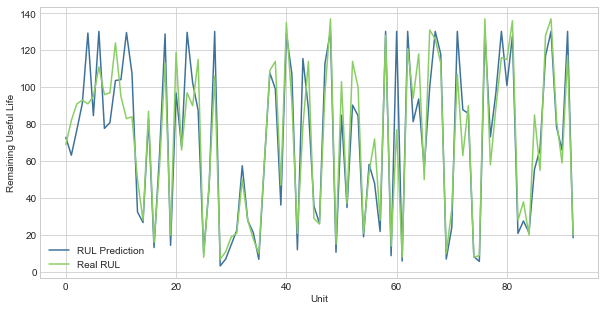

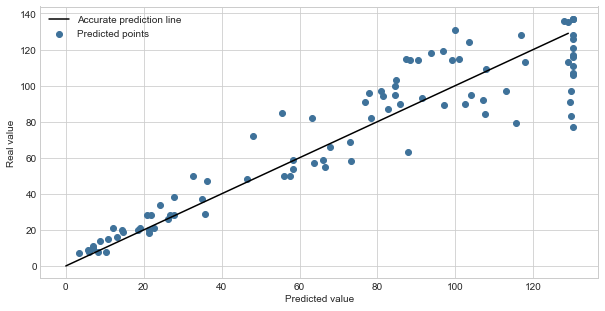

In [11]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['Unit']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['Unit'].unique() if len(test_df[test_df['Unit']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['Unit']==id]) >= sequence_length for id in test_df['Unit'].unique()]
label_array_test_last = test_df.groupby('Unit')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()

In [12]:
print("The computed challenge score is: S = {}".format(Computed_Score(y_true_test, y_pred_test)))

The computed challenge score is: S = [365.34045]
